In [1]:
#!pip install nvidia-ml-py3
#!yes | pip uninstall torchvision
#!pip install torchvision

# PyTorch Batch Inference
In this notebook, we'll examine how to do batch transform task with PyTorch in Amazon SageMaker. Throughout the Notebook, terms "Batch Inference" and "Batch Transform" are used interchangeably.

We use an previously built MNIST dataset image classification model. Then, we demonstrate batch transform by using SageMaker Python SDK PyTorch framework. For a more extensive example demonstrating how to build a model as well as how to run batch inference using a manifest file as well as distributed batch inference, please, see the original version of this notebook: 
https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker_batch_transform/pytorch_mnist_batch_transform/pytorch-mnist-batch-transform.ipynb

For batch transform in TensorFlow in Amazon SageMaker, you can follow other Jupyter notebooks [here](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker_batch_transform)

![inference_overview](notebook_images/inference_overview_image_1.png)

![batch_inference_focus](notebook_images/batch_inference_focus_image_2.png)

![batch_inference](notebook_images/batch_inference_image_3.png)

## Setup
We'll begin with some necessary imports, and get an Amazon SageMaker session to help perform certain tasks, as well as an IAM role with the necessary permissions.

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from shutil import copyfile
import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-batch-inference-script"
print("Bucket:  {}".format(bucket))

Matplotlib is building the font cache; this may take a moment.


Bucket:  sagemaker-us-west-2-328296961357


In [3]:
#uncompress 100 MNIST images which we will use for batch inference
!tar -xf data/images.tar.gz
!mv images/ data/images/

In [4]:
inference_prefix = "batch_transform"
local_image_dir = "data/images"
local_model_dir = "model"
local_output_path = "output"
s3_model_location_prefix = os.path.join(prefix, inference_prefix, "model")
s3_model_location = sagemaker_session.upload_data(path=local_model_dir, bucket=bucket, 
                        key_prefix=s3_model_location_prefix)
s3_model_location = os.path.join(s3_model_location, "model.tar.gz")

s3_inference_image_location_prefix = os.path.join(prefix, inference_prefix, "inference_images")
inference_inputs = sagemaker_session.upload_data(
                        path=local_image_dir, bucket=bucket, key_prefix=s3_inference_image_location_prefix)

s3_prediction_output_prefix = os.path.join(prefix, inference_prefix, "prediction_output")
s3_prediction_output_path = os.path.join("s3://", bucket, prefix, inference_prefix, "prediction_output")

# Create model transformer
Now, we will create a transformer object for handling creating and interacting with Amazon SageMaker transform jobs.

Here, we implement the `model_fn`, `input_fn`, `predict_fn` and `output_fn` function to override the default [PyTorch inference handler](https://github.com/aws/sagemaker-pytorch-inference-toolkit/blob/master/src/sagemaker_pytorch_serving_container/default_inference_handler.py). 

It is noted that in `input_fn` function, the inferenced images are encoded as a Python ByteArray. That's why we use `load_from_bytearray` function to load image from `io.BytesIO` then use `PIL.image` to read.

```python
def model_fn(model_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.nn.DataParallel(Net())
    with open(os.path.join(model_dir, 'model.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f))
    return model.to(device)

    
def load_from_bytearray(request_body):
    image_as_bytes = io.BytesIO(request_body)
    image = Image.open(image_as_bytes)
    image_tensor = ToTensor()(image).unsqueeze(0)    
    return image_tensor


def input_fn(request_body, request_content_type):
    # if set content_type as 'image/jpg' or 'applicaiton/x-npy', 
    # the input is also a python bytearray
    if request_content_type == 'application/x-image': 
        image_tensor = load_from_bytearray(request_body)
    else:
        print("not support this type yet")
        raise ValueError("not support this type yet")
    return image_tensor


# Perform prediction on the deserialized object, with the loaded model
def predict_fn(input_object, model):
    output = model.forward(input_object)
    pred = output.max(1, keepdim=True)[1]

    return {'predictions':pred.item()}


# Serialize the prediction result into the desired response content type
def output_fn(predictions, response_content_type):
    return json.dumps(predictions)
```

In [5]:
#Creating a Transformer object from saved model artifact

pytorch_model = PyTorchModel(
    model_data=s3_model_location,
    role=role,
    framework_version="1.8.0",
    py_version="py3",
    source_dir="model-script/",
    entry_point="mnist.py",
)

# then create transformer from PyTorchModel object
transformer = pytorch_model.transformer(instance_count=1, instance_type="ml.c5.xlarge", 
                                        output_path=s3_prediction_output_path,)

### Running Batch Inference 
We will use 100 MNIST images for batch inference.
The next cell takes ~5 minutes to execute. Most of this time is spent provisioning an EC2 instance and running health checks. The actual inference time for 100 images is less than one minute. You can see it in CloudWatch timestamps.

We set `S3DataType=S3Prefix` to use all objects that match the specified S3 key name prefix for batch inference.

In [6]:
my_transformer = transformer.transform(
    data=inference_inputs,
    data_type="S3Prefix",
    content_type="application/x-image",
    wait=True,
)

.................................2022-01-20 00:15:39,886 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.3.0
TS Home: /opt/conda/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 4
Max heap size: 946 M
Python executable: /opt/conda/bin/python3.6
Config file: /etc/sagemaker-ts.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Metrics address: http://127.0.0.1:8082
Model Store: /.sagemaker/ts/models
Initial Models: model.mar
Log dir: /logs
Metrics dir: /logs
Netty threads: 0
Netty client threads: 0
Default workers per model: 4
Blacklist Regex: N/A
Maximum Response Size: 6553500
Maximum Request Size: 6553500
Prefer direct buffer: false
Allowed Urls: [file://.*|http(s)?://.*]
Custom python dependency for model allowed: false
Metrics report format: prometheus
Enable metrics API: true
2022-01-20 00:15:39,918 [INFO ] main org.pytorch.serve.ModelServer - Loading i

2022-01-20T00:15:47.529:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
2022-01-20 00:15:52,612 [INFO ] W-9002-model_1 org.pytorch.serve.wlm.WorkerThread - Backend response time: 2
2022-01-20 00:15:52,612 [INFO ] W-9002-model_1-stdout MODEL_METRICS - PredictionTime.Milliseconds:1.36|#ModelName:model,Level:Model|#hostname:fdd7ad5e4df7,requestID:01ab99cb-297e-406e-9b8b-9e89c0810696,timestamp:1642637752
2022-01-20 00:15:52,613 [INFO ] W-9002-model_1 ACCESS_LOG - /169.254.255.130:39562 "POST /invocations HTTP/1.1" 200 4
2022-01-20 00:15:52,613 [INFO ] W-9002-model_1 TS_METRICS - Requests2XX.Count:1|#Level:Host|#hostname:fdd7ad5e4df7,timestamp:null
2022-01-20 00:15:52,613 [INFO ] W-9002-model_1 TS_METRICS - QueueTime.ms:0|#Level:Host|#hostname:fdd7ad5e4df7,timestamp:null
2022-01-20 00:15:52,613 [INFO ] W-9002-model_1 TS_METRICS - WorkerThreadTime.ms:1|#Level:Host|#hostname:fdd7ad5e4df7,timestamp:null
2022-01-20 00:15:52,612 [INFO ] W-9002-model_1 or

### Some useful methods to see the status of your batch inference jobs.

In [7]:
print("latest transform job \n", transformer.latest_transform_job.name)

latest transform job 
 pytorch-inference-2022-01-20-00-10-22-314


In [8]:
# look at the status of the transform job
import boto3
import pprint as pp

sm_cli = boto3.client("sagemaker")

res = sm_cli.describe_transform_job(TransformJobName=transformer.latest_transform_job.name)

pp.pprint(res)

{'CreationTime': datetime.datetime(2022, 1, 20, 0, 10, 22, 572000, tzinfo=tzlocal()),
 'DataProcessing': {'InputFilter': '$',
                    'JoinSource': 'None',
                    'OutputFilter': '$'},
 'ModelName': 'pytorch-inference-2022-01-20-00-10-21-975',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '996',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Thu, 20 Jan 2022 00:16:40 GMT',
                                      'x-amzn-requestid': 'cf36eb8f-a47c-4f5b-8e38-af7e04b95c69'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'cf36eb8f-a47c-4f5b-8e38-af7e04b95c69',
                      'RetryAttempts': 0},
 'TransformEndTime': datetime.datetime(2022, 1, 20, 0, 16, 3, 517000, tzinfo=tzlocal()),
 'TransformInput': {'CompressionType': 'None',
                    'ContentType': 'application/x-image',
                    'DataSource': {'S3DataSource'

### Download batch inference results from S3 to your local Jupyter Notebook machine.

In [9]:
from time import sleep
sleep(5)
sagemaker_session.download_data(path=local_output_path, bucket=bucket, key_prefix=s3_prediction_output_prefix)

In [10]:
!ls {local_output_path}

0.png.out   25.png.out	40.png.out  56.png.out	71.png.out  87.png.out
10.png.out  26.png.out	41.png.out  57.png.out	72.png.out  88.png.out
11.png.out  27.png.out	42.png.out  58.png.out	73.png.out  89.png.out
12.png.out  28.png.out	43.png.out  59.png.out	74.png.out  8.png.out
13.png.out  29.png.out	44.png.out  5.png.out	75.png.out  90.png.out
14.png.out  2.png.out	45.png.out  60.png.out	76.png.out  91.png.out
15.png.out  30.png.out	46.png.out  61.png.out	77.png.out  92.png.out
16.png.out  31.png.out	47.png.out  62.png.out	78.png.out  93.png.out
17.png.out  32.png.out	48.png.out  63.png.out	79.png.out  94.png.out
18.png.out  33.png.out	49.png.out  64.png.out	7.png.out   95.png.out
19.png.out  34.png.out	4.png.out   65.png.out	80.png.out  96.png.out
1.png.out   35.png.out	50.png.out  66.png.out	81.png.out  97.png.out
20.png.out  36.png.out	51.png.out  67.png.out	82.png.out  98.png.out
21.png.out  37.png.out	52.png.out  68.png.out	83.png.out  99.png.out
22.png.out  38.png.out	53.png.out  69

['1 ', '4 ', '0 ', '1 ', '4 ', '8 ', '0 ', '1 ', '9 ', '9 ', '2 ', '9 ', '7 ', '3 ', '0 ', '8 ']


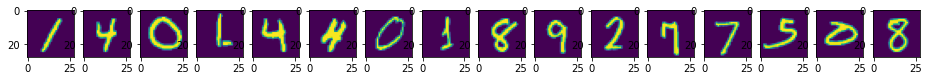

In [11]:
# display .png image files and corresponding predictions
import json
import matplotlib.pyplot as plt
import matplotlib.image as img
N_files = 16

im_list = []
pred_list = []

for i in range(N_files):
    image_path=os.path.join(local_image_dir, f"{i}.png")
    im_list.append(img.imread(image_path))
    
    pred_path = os.path.join(local_output_path, f"{i}.png.out")
    with open(pred_path, "r") as F:
        item=json.load(F)
        pred_list.append( str(item["predictions"])+ " ")    
    
# plot the images
fig, axs = plt.subplots(nrows=1, ncols=N_files, figsize=(16, 1))
for k, splt in enumerate(axs):
    splt.imshow(im_list[k])
    
print(pred_list)

In [12]:
# Inspect the output

import json

for f in os.listdir(local_output_path):
    path = os.path.join(local_output_path, f)
    with open(path, "r") as f:
        pred = json.load(f)
        print(pred)

{'predictions': 1}
{'predictions': 6}
{'predictions': 5}
{'predictions': 0}
{'predictions': 2}
{'predictions': 7}
{'predictions': 3}
{'predictions': 7}
{'predictions': 9}
{'predictions': 5}
{'predictions': 1}
{'predictions': 3}
{'predictions': 1}
{'predictions': 0}
{'predictions': 0}
{'predictions': 0}
{'predictions': 5}
{'predictions': 8}
{'predictions': 2}
{'predictions': 9}
{'predictions': 8}
{'predictions': 3}
{'predictions': 9}
{'predictions': 3}
{'predictions': 5}
{'predictions': 2}
{'predictions': 7}
{'predictions': 1}
{'predictions': 1}
{'predictions': 5}
{'predictions': 1}
{'predictions': 3}
{'predictions': 4}
{'predictions': 9}
{'predictions': 4}
{'predictions': 5}
{'predictions': 6}
{'predictions': 8}
{'predictions': 4}
{'predictions': 4}
{'predictions': 1}
{'predictions': 8}
{'predictions': 9}
{'predictions': 4}
{'predictions': 7}
{'predictions': 8}
{'predictions': 6}
{'predictions': 7}
{'predictions': 0}
{'predictions': 7}
{'predictions': 6}
{'predictions': 5}
{'prediction